In [656]:
import numpy as np
import pandas as pd

output_folder_name = "../output/"

## Parameters
no_adoption_decline_parameter = 1.0 #  Reasonable probably

# Intermediate steps for calculating the calibrated parameter
kappa_ni = 8.89 / (8.89 - 0.89)
kappa__AV = 8.89 / (8.89 - 0.27 * 0.89)

# Taking the ratio to get the calibrated parameter
full_adoption_decline_parameter = kappa__AV / kappa_ni

alpha = 0.6
sigma = 4.0 
psi = -1.2922/(1 - sigma)#should estimate from data
local = "/Users/jeffreyohl/Dropbox/SpatialW25/BigDataFiles/"

combined_fips_map = {
    "51945": ["51163", "51530", "51678"],
    "51901": ["51003", "51540"],
    "51918": ["51053", "51570", "51730"],
    "51939": ["51143", "51590"],
    "51931": ["51095", "51830"],
    "51907": ["51015", "51790", "51820"],
    "2232":  ["2232"],
    "51913": ["51035", "51640"],
    "51958": ["51199", "51735"],
    "51929": ["51089", "51690"],
    "51953": ["51191", "51520"],
    "51951": ["51177", "51630"],
    "51955": ["51195", "51720"],
    "51923": ["51081", "51595"],
    "51909": ["51019", "51515"],
    "51942": ["51153", "51683", "51685"],
    "51921": ["51069", "51840"],
    "2201":  ["2201"],
    "51947": ["51165", "51660"],
    "15901": ["15009", "15005"],
    "2280":  ["2280"],
    "51911": ["51031", "51680"],
    "51944": ["51161", "51775"],
    "51949": ["51175", "51620"],
    "51941": ["51149", "51670"],
    "51903": ["51005", "51580"],
    "51919": ["51059", "51600", "51610"],
    "51933": ["51121", "51750"],
}
dropped_fips = list(combined_fips_map.keys())


In [322]:
len(dropped_fips)

28

In [323]:
full_adoption_decline_parameter

0.9248875683549718

# Data 

In [324]:
## Initial API Call
import requests
import pandas as pd
from urllib.parse import quote

def get_county_education_2010():
   api_key = "488b0df48f856b207eae540095aee8cd37926d3a"
   base_url = "https://api.census.gov/data/2010/acs/acs5"
   variables = [
     "B15002_001E",  # Total population 25+
       "B15002_015E",  # Male: Bachelor's degree
       "B15002_016E",  # Male: Master's degree 
       "B15002_017E",  # Male: Professional school degree
       "B15002_018E",  # Male: Doctorate degree
       "B15002_032E",  # Female: Bachelor's degree
       "B15002_033E",  # Female: Master's degree
       "B15002_034E",  # Female: Professional school degree
       "B15002_035E"   # Female: Doctorate degree
    ]
   
   # Build URL
   get_vars = quote(",".join(variables))
   url = f"{base_url}?get=NAME,{get_vars}&for=county:*&in=state:*&key={api_key}"
   
   print(f"Requesting URL: {url}")
   
   try:
       response = requests.get(url)
       print(f"Status code: {response.status_code}")
       
       if response.status_code != 200:
           raise Exception(f"API returned status code {response.status_code}")
           
       # Parse JSON into DataFrame
       data = response.json()
       df = pd.DataFrame(data[1:], columns=data[0])
       
       # Convert to numeric
       for var in variables:
           df[var] = pd.to_numeric(df[var])
           
       # Calculate bachelors or higher (sum male and female)
       df['bachelors_plus'] = (
           df['B15002_015E'] + df['B15002_016E'] + df['B15002_017E'] + df['B15002_018E'] +  # Male
           df['B15002_032E'] + df['B15002_033E'] + df['B15002_034E'] + df['B15002_035E']    # Female
       )
       
       # Calculate percentage
       df['pct_bachelors_plus'] = (df['bachelors_plus'] / df['B15002_001E']).round(8)
       df['total'] = df['B15002_001E']
       # Select and rename columns
       final_df = df[['NAME', 'state', 'county', 'pct_bachelors_plus', 'total']]
       
       # Save to CSV
       #final_df.to_csv('county_bachelors_2006_2010.csv', index=False)
       #print("\nSaved to county_bachelors_2006_2010.csv")
       
       return final_df
       
   except requests.exceptions.RequestException as e:
       print(f"Request failed: {e}")
       raise
   except ValueError as e:
       print(f"JSON parsing failed: {e}")
       print(f"Raw response: {response.text}")
       raise

if __name__ == '__main__':
   try:
       county_data = get_county_education_2010()
       print("\nFirst few rows:")
       print(county_data.head())
   except Exception as e:
       print(f"Error: {e}")
# Construct FIPs without leading zeros for consistency with Monte et al code
county_data['FIPS'] = county_data['state'].astype(str) + county_data['county'].astype(str)
county_data['FIPS'] = county_data['FIPS'].str.lstrip('0')
county_data['FIPS']  = county_data['FIPS'].astype(int)
county_data.sort_values(by="FIPS",ascending=True)


Requesting URL: https://api.census.gov/data/2010/acs/acs5?get=NAME,B15002_001E%2CB15002_015E%2CB15002_016E%2CB15002_017E%2CB15002_018E%2CB15002_032E%2CB15002_033E%2CB15002_034E%2CB15002_035E&for=county:*&in=state:*&key=488b0df48f856b207eae540095aee8cd37926d3a
Status code: 200

First few rows:
                                NAME state county  pct_bachelors_plus  total
0  Las Marías Municipio, Puerto Rico    72    083            0.123230   6427
1  San Germán Municipio, Puerto Rico    72    125            0.196672  23801
2     Comerío Municipio, Puerto Rico    72    045            0.119509  12953
3   Canóvanas Municipio, Puerto Rico    72    029            0.185542  29341
4      Rincón Municipio, Puerto Rico    72    117            0.188367  10384


,NAME,state,county,pct_bachelors_plus,total,FIPS
399,"Autauga County, Alabama",01,001,0.217477,33884,1001
400,"Baldwin County, Alabama",01,003,0.268221,121560,1003
401,"Barbour County, Alabama",01,005,0.135124,18879,1005
402,"Bibb County, Alabama",01,007,0.100252,15082,1007
403,"Blount County, Alabama",01,009,0.125272,38085,1009
...,...,...,...,...,...,...
3085,"Vega Baja Municipio, Puerto Rico",72,145,0.172483,38572,72145
3086,"Vieques Municipio, Puerto Rico",72,147,0.132066,6103,72147
3087,"Villalba Municipio, Puerto Rico",72,149,0.156759,15712,72149
3088,"Yabucoa Municipio, Puerto Rico",72,151,0.132665,24430,72151


In [325]:
def get_state_code_from_fips(fips_str: str) -> str:
    """
    If FIPS has length 5, we use the first two digits as the state code.
    If FIPS has length 4, we prepend '0' + the first digit, e.g. '2232' -> '02'.
    """
    fips_str = str(fips_str)
    if len(fips_str) == 5:
        return fips_str[:2]
    elif len(fips_str) == 4:
        return "0" + fips_str[0]
    else:
        return None


In [326]:
import pandas as pd

# Ensure FIPS is string
county_data['FIPS'] = county_data['FIPS'].astype(str)

# Group by 'state' to find each state's weighted average of 'pct_bachelors_plus'
#   and the sum of 'total'
state_agg = county_data.groupby('state').apply(
    lambda g: pd.Series({
        'state_total': g['total'].sum(),
        'state_wavg': (
            (g['pct_bachelors_plus'] * g['total']).sum() / g['total'].sum()
        ) if g['total'].sum() else 0
    })
).reset_index()

# Convert the above into a dict for quick lookup: state_code -> (weighted_avg, total)
state_fallback = {
    row['state']: {
        'pct_bachelors_plus': row['state_wavg'],
        'total': row['state_total']
    }
    for _, row in state_agg.iterrows()
}


/var/folders/g9/ggrmf_5j6tx4rv5qdhs0slq40000gn/T/ipykernel_83250/154169215.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  state_agg = county_data.groupby('state').apply(


In [327]:
# 1) Collect all old FIPS (not strictly needed if we no longer remove them)
all_old_fips = set()
for new_fips, old_list in combined_fips_map.items():
    new_fips_str = str(new_fips)
    combined_fips_map[new_fips_str] = [str(x) for x in old_list]
    all_old_fips.update(combined_fips_map[new_fips_str])

# 2) Build a dict of new rows to add
agg_results = {}

for new_fips, old_fips_list in combined_fips_map.items():
    # Subset to the old FIPS rows
    subset_df = county_data[county_data['FIPS'].isin(old_fips_list)]
    
    if subset_df.empty:
        # --- Fallback to the state-level average ---
        st_code = get_state_code_from_fips(new_fips)
        if st_code in state_fallback:
            wavg = state_fallback[st_code]['pct_bachelors_plus']
            total_sum = state_fallback[st_code]['total']
        else:
            wavg = 0
            total_sum = 0
        the_state = st_code  # or None if unknown
    else:
        # --- Compute weighted average from subset ---
        total_sum = subset_df['total'].sum()
        wavg = 0 if total_sum == 0 else (
            (subset_df['pct_bachelors_plus'] * subset_df['total']).sum()
            / total_sum
        )
        # If all old FIPS belong to one state, we can pick that:
        unique_states = subset_df['state'].unique()
        the_state = unique_states[0] if len(unique_states) == 1 else None

    # Build the new row
    new_row = {
        'NAME'              : f'Aggregate_{new_fips}',
        'state'             : the_state,
        'county'            : None,
        'pct_bachelors_plus': wavg,
        'total'             : total_sum,
        'FIPS'              : new_fips
    }
    agg_results[new_fips] = new_row

# 3) We DO NOT remove any existing rows. Just append.
df_new = pd.DataFrame(agg_results.values(), columns=county_data.columns)

# 4) Append to county_data
county_data = pd.concat([county_data, df_new], ignore_index=True)

print(county_data.tail())

                 NAME state county  pct_bachelors_plus     total   FIPS
3244  Aggregate_51949    51   None            0.145379   18751.0  51949
3245  Aggregate_51941    51   None            0.147125   37723.0  51941
3246  Aggregate_51903    51   None            0.137291   15886.0  51903
3247  Aggregate_51919    51   None            0.580734  732829.0  51919
3248  Aggregate_51933    51   None            0.388680   54505.0  51933


In [328]:
county_data['FIPS']

0       72083
1       72125
2       72045
3       72029
4       72117
        ...  
3244    51949
3245    51941
3246    51903
3247    51919
3248    51933
Name: FIPS, Length: 3249, dtype: object

In [ ]:
import pandas as pd 
# Raw Data.
in_distance = local + "bilateral_distances.dta"
distances = pd.read_stata(in_distance) # note we can't upload this too github it is too big
flows = pd.read_stata("../data/Monte et al 2018 Replication Folder/CMLEE.dta") # i am pulling from esteban's dataset for this
land_area = pd.read_csv('../data/Raw Data/CountyCentroids2010.txt',  # From Census. 
                delimiter='\t',
                encoding='latin-1')
land_area = (
    land_area[['GEOID', 'ALAND']]
    .drop_duplicates()                # remove duplicates based on entire row
    .sort_values(by='GEOID', ascending=True)
)

land_area = land_area[['ALAND', 'GEOID']]



/var/folders/g9/ggrmf_5j6tx4rv5qdhs0slq40000gn/T/ipykernel_83250/60572968.py:5: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  flows = pd.read_stata("../data/Monte et al 2018 Replication Folder/CMLEE.dta") # i am pulling from esteban's dataset for this



### First step is to find the eligible counties for our analysis.


In [ ]:
# Use this for calculating data that we have commute flows, etc. on. 
pop_weights = (
    flows[['state_county_res', 'residence_emp']]
    .drop_duplicates()                # remove duplicates based on entire row
    .sort_values(by='state_county_res', ascending=True)
)

print(len(county_data))
print(len(pop_weights))
# --- Merge Education Data and Population data  -- 
# Ensure the columns are the same type before merging
county_data['FIPS'] = county_data['FIPS'].astype(str)
pop_weights['state_county_res'] = pop_weights['state_county_res'].astype(str)

df_merged = county_data.merge(
    pop_weights, 
    left_on='FIPS', 
    right_on='state_county_res', 
    how='inner'
).sort_values('FIPS')

print(len(df_merged))
counties_for_inclusion = df_merged.FIPS.unique() # some dont have education data, we can't include those in our analysis
#####

3249
3111
3111


In [333]:
set(pop_weights['state_county_res']) - set(counties_for_inclusion)

set()

## Here I attempt to reconstruct county-level things

# Compute college-shares for later.

In [334]:
# Extract the relevant arrays
pct = df_merged['pct_bachelors_plus'].values
emp = df_merged['residence_emp'].values
# 2) Extract arrays for shares (pct) and employment (emp).
pct = df_merged['pct_bachelors_plus'].to_numpy()
emp = df_merged['residence_emp'].to_numpy()

# 3) Vectorized pairwise workplace-weighted averages:
#    arr[i,j] = (pct[i]*emp[i] + pct[j]*emp[j]) / (emp[i] + emp[j])
numerator   = (pct * emp)[:, None] + (pct * emp)[None, :]
denominator = emp[:, None] + emp[None, :]
scaling = numerator / denominator ## this is the pairwise workplace weighted average of the shares of bachelors degrees, we will use this to scale commute costs.
####
scaling.shape


(3111, 3111)

# Convert things to np arrays

# I am keeping everything in ascending by FIPs order

In [269]:
## Pull key quantities from Esteban's data. 
residence_emp = (
    flows[['state_county_res', 'residence_emp']]
    .drop_duplicates()                # remove duplicates based on entire row
    .sort_values(by='state_county_res', ascending=True)
)


workplace_emp = (
    flows[['state_county_work', 'workplace_emp']]
    .drop_duplicates()                # remove duplicates based on entire row
    .sort_values(by='state_county_work', ascending=True)
)


avgw_pow = (
    flows[['state_county_work', 'avgw_pow']]
    .drop_duplicates()  # remove duplicate rows
    .sort_values(by='state_county_work')
)
land_area = land_area.sort_values(by='GEOID', ascending=True)




In [270]:
print(residence_emp['residence_emp'] .sum())

print(workplace_emp['workplace_emp'].sum())

179874700.0
179874700


In [271]:
flows[flows['state_county_work'] == 1097].commuting.sum()

np.float32(234724.98)

In [272]:
flows[flows['state_county_work'] == 1097].workplace_emp.mean()

np.float64(234725.0)

In [273]:
# Vectors we need for the model
workemp   =  np.array(workplace_emp['workplace_emp'])
workwage  = np.array(avgw_pow['avgw_pow'])
    

H_n = np.array(land_area['ALAND'])
    
# Suppose R (residents), D, vbar are also known (random example):
R_n    = np.array(residence_emp['residence_emp']) 

In [276]:
import pandas as pd

# Suppose your DataFrame is named 'flows'.

# Group by 'state_county_work' and 'state_fips_work'
check_df = (
    flows
    .groupby(['state_county_work'], as_index=False)
    .agg(
        total_commuting=('commuting', 'sum'),
        unique_workplace_emp=('workplace_emp', 'unique')
    )
)

# For convenience, we define a helper to extract a *single* workplace_emp if it is unique
def get_unique_or_none(arr):
    """Return the single element in arr if there's exactly one, else None."""
    if len(arr) == 1:
        return arr[0]
    else:
        return None

# Create a column with a single (unique) workplace_emp per group, or None if multiple
check_df['single_workplace_emp'] = check_df['unique_workplace_emp'].apply(get_unique_or_none)

# Compute the divergence: workplace_emp - sum_of_commuting
check_df['divergence'] = check_df['single_workplace_emp'] - check_df['total_commuting']

# Print the results
# Also, flag rows that have multiple distinct workplace_emp values
for idx, row in check_df.iterrows():
    state_fips = row['state_county_work']
    divergence = row['divergence']
    workplace_vals = row['unique_workplace_emp']
    
    # If there's more than one unique workplace_emp, you can decide how to handle:
    if len(workplace_vals) > 1:
        print(f"[WARNING] {row['state_county_work']} (fips={state_fips}) has multiple workplace_emp values: {workplace_vals}")
    else:
        print(f"state_fips_work={state_fips}, divergence={divergence}")


state_fips_work=1001, divergence=0.0
state_fips_work=1003, divergence=0.0
state_fips_work=1005, divergence=-0.0009765625
state_fips_work=1007, divergence=0.0
state_fips_work=1009, divergence=0.0
state_fips_work=1011, divergence=0.00048828125
state_fips_work=1013, divergence=0.0
state_fips_work=1015, divergence=0.0
state_fips_work=1017, divergence=0.0
state_fips_work=1019, divergence=0.0009765625
state_fips_work=1021, divergence=0.0
state_fips_work=1023, divergence=0.00048828125
state_fips_work=1025, divergence=0.0009765625
state_fips_work=1027, divergence=0.0
state_fips_work=1029, divergence=0.0
state_fips_work=1031, divergence=0.0
state_fips_work=1033, divergence=-0.001953125
state_fips_work=1035, divergence=0.0
state_fips_work=1037, divergence=0.0
state_fips_work=1039, divergence=0.0
state_fips_work=1041, divergence=0.0
state_fips_work=1043, divergence=0.0
state_fips_work=1045, divergence=0.0
state_fips_work=1047, divergence=0.0
state_fips_work=1049, divergence=0.0
state_fips_work=10

In [277]:
check_df['divergence'].mean()

np.float64(-8.929653284213276e-05)

In [ ]:
# 1) Compute the pivot table using sum for duplicates (if needed) and fill with 0
df_pivot = flows.pivot_table(
    index='state_county_res',
    columns='state_county_work',
    values='commuting',
    aggfunc='sum',      # sum over duplicates
    fill_value=0
)

# 2) Sort rows and columns in ascending order
df_pivot = df_pivot.sort_index().sort_index(axis=1)

# 3) Divide by the sum of commuting over the entire DataFrame, so each cell becomes a share
total_commuting = flows['commuting'].sum()
df_pivot = df_pivot / total_commuting


lambda_ni = np.array(df_pivot)
lambda_nR = lambda_ni.sum(axis=1)
# Broadcast division over each row using [:, None] to match dimensions
lambda_ni_given_n = lambda_ni / lambda_nR[:, None]   # shape: (N, M)
#vbar_n = (lambda_ni_given_n * workwage).sum(axis=1)  # shape: (N,)

In [ ]:

replication_data = pd.read_csv("../data/Monte et al 2018 Replication Folder/data_for_reduced_form_fullTD.csv")
# These require some math, so for now, take it from data

D_n = np.array(replication_data["deficit"])* 1000000
A_solution = np.array(replication_data["productivity"])

#resemp_rep = pd.read_csv("../data/Monte et al 2018 Replication Folder/residentialEmp.csv",header=None)
R_n =np.array(replication_data['resemp'])




#reswage_rep = pd.read_csv("../data/Monte et al 2018 Replication Folder/residentialWage.csv",header=None)


#workemp_rep = pd.read_csv("../data/Monte et al 2018 Replication Folder/workplaceEmp.csv",header=None)
#workempwage_rep = pd.read_csv("../data/Monte et al 2018 Replication Folder/workplaceWage.csv",header=None)

vbar_n = np.array(replication_data['resWage'])
L_i =np.array(replication_data['workplaceemp'])
w_i = np.array(replication_data['workplacewage'])
# DISTANCES WITH 10^9 FOR NO TRADING
dist_ni = pd.read_csv("../data/Monte et al 2018 Replication Folder/distances_onlytrading.csv", header=None)

total_res_exp = vbar_n * R_n
total_res_income = w_i * L_i
# 3. Convert the pivoted DataFrame to a NumPy array, and transpose it because they use different conventions
dist_ni = dist_ni.to_numpy()


d_ni = dist_ni**psi

pd.DataFrame(d_ni).to_csv(local + "d_ni.csv", index=False, header=False)

# 3. Save L_i
pd.DataFrame(L_i).to_csv("../output/L_i.csv", index=False, header=False)

# 4. Save A_solution (productivities)
pd.DataFrame(A_solution).to_csv("../output/productivities.csv", index=False, header=False)

# 5. Save R_n
pd.DataFrame(R_n).to_csv("../output/R_n.csv", index=False, header=False)

# 6. Save vbar_n
pd.DataFrame(vbar_n).to_csv("../output/Vbar_n.csv", index=False, header=False)

# 7. Save w_i
pd.DataFrame(w_i).to_csv("../output/w_i.csv", index=False, header=False)



In [783]:

# 8. Save D_n
pd.DataFrame(D_n).to_csv("../output/D_n.csv", index=False, header=False)

In [784]:
D_n

array([3.54986608e+08, 1.25097863e+08, 1.19987819e+08, ...,
       1.66743161e+08, 5.51442419e+07, 5.47398359e+07])

In [751]:
diffs = total_res_income.sum() - total_res_exp.sum()

In [772]:
def ERH_compute_shares(prod, workemp, workwage, distmatrix, sigma, psi):
    """
    Returns the bilateral shares array corresponding to
    the 'share' step in your Mathematica code.
    
    Parameters
    ----------
    prod       : 1D array (dimension N)
    workemp    : 1D array (dimension N)
    workwage   : 1D array (dimension N)
    distmatrix : 2D array (N x N)
    sigma      : float
    psi        : float

    Returns
    -------
    shares : 2D array (N x N)
    """
    # 1) Construct the numerator:
    #    num = workemp * (workwage^(1-sigma)) * (distmatrix^(psi*(1-sigma))) * 10^4
    #    (Broadcast rules will expand each 1D vector along rows or columns as needed.)
    num = (
        workemp[:, None] *                     # shape (N,1)
        (workwage[:, None] ** (1.0 - sigma)) *  # shape (N,1)
        (distmatrix ** (psi * (1.0 - sigma))) 
    )

    # 2) bilatRes = num * (prod^(sigma-1))
    bilatRes = num * (prod[:, None] ** (sigma - 1.0))

    # 3) We sum across rows (i) for each column (j)
    #    to get the 'multResistance' for each destination j:
    multResistance = bilatRes.sum(axis=0)  # shape (N,)

    # 4) Finally, share = bilatRes / multResistance (by column)
    #    This divides each column j by the sum of that column.
    shares = bilatRes / multResistance

    return shares
pi_ni = compute_shares(A_solution, L_i, w_i, dist_ni, sigma,psi)

In [773]:
# We take the transpose because Esteban's dist_ni is flipped from ours.

In [774]:
pi_ni = pi_ni.T

In [775]:
pi_ni

array([[1.83820125e-02, 2.93822337e-03, 7.91994035e-04, ...,
        2.60886094e-12, 1.09152410e-12, 8.30844549e-13],
       [6.79268259e-04, 7.39413020e-02, 4.63164421e-04, ...,
        3.45695544e-12, 1.44635926e-12, 1.10093740e-12],
       [1.06390466e-03, 2.69128368e-03, 1.17485335e-02, ...,
        2.74885895e-12, 1.15009802e-12, 8.75429750e-13],
       ...,
       [2.39471811e-12, 2.56865792e-04, 1.87834397e-12, ...,
        2.68729950e-02, 3.84290481e-04, 1.70297674e-04],
       [2.93480363e-12, 3.27917593e-04, 2.30197061e-12, ...,
        1.12564611e-03, 1.31456168e-02, 6.06044035e-04],
       [2.84645721e-12, 3.58596114e-04, 2.23267437e-12, ...,
        6.35609139e-04, 7.72224094e-04, 9.28272406e-03]])

# Maybe? 

In [776]:
 # Sum along rows (axis 1)
row_sums = np.sum(pi_ni, axis=1)
print(row_sums)
 # Sum along columns (axis 0)
col_sums = np.sum(pi_ni, axis=0)
print(col_sums)

[1. 1. 1. ... 1. 1. 1.]
[0.40530904 1.51255042 0.32055551 ... 0.43989702 0.20031059 0.17321107]


In [777]:
col_sums.max()

np.float64(52.03375715082644)

# I am just going to use his data for everything except pi_ni now. 

In [778]:
import numpy as np

def check_balance(workwage, workemp, pi, total_res_exp, D_n):
    """
    Checks w_i * L_i = sum_n pi_{n,i} * vbar_n * R_n for each i.
    
    Parameters
    ----------
    workwage : 1D array of shape (N,)
        The wages w_i
    workemp : 1D array of shape (N,)
        The employment L_i
    pi : 2D array of shape (N,N)
        The matrix pi_{n,i}, from compute_pi
    vbar : 1D array of shape (N,)
        The vector vbar_n
    R : 1D array of shape (N,)
        The vector R_n

    Returns
    -------
    lhs : 1D array (N,)
        The left-hand side, w_i * L_i
    rhs : 1D array (N,)
        The right-hand side, sum_n pi_{n,i} * vbar_n * R_n
    difference : 1D array (N,)
        The elementwise difference (lhs - rhs)
    """
    # LHS: w_i * L_i
    lhs = workwage * workemp  # shape (N,)

    # RHS: sum over n of pi_{n,i} * vbar_n * R_n
    #  - pi is shape (N x N).  Multiply each row n by (vbar_n * R_n),
    #    then sum down rows (axis=0) to get an array of length N (one for each i).
    rhs = np.sum(pi * (total_res_exp +  D_n )[:, np.newaxis], axis=0)  # shape (N,)

    diff = lhs - rhs
    return lhs, rhs, diff

# Then inspect diff to see how close each i's equation is to zero.

lhs, rhs, diff = check_balance(w_i, L_i, pi_ni,total_res_exp, D_n)

In [779]:
rhs.sum() - lhs.sum()

np.float64(100500.26171875)

In [780]:
lhs.sum()

np.float64(8872297054804.07)

In [781]:
np.mean(np.abs(lhs - rhs)/lhs)



np.float64(1.2493475186617853e-08)

In [782]:
pi_ni = pd.DataFrame(pi_ni)
import pandas as pd

# Assume pi_ni is either an existing DataFrame or a NumPy array
# Also assume replication_data['state_county_code'] is a list (or Series) of length n,
# matching the dimension of pi_ni (n x n).

codes = replication_data['state_county_code']

# If pi_ni is already a DataFrame, you can just assign the row/column labels:
pi_ni.index = codes
pi_ni.columns = codes

# If pi_ni is a NumPy array, wrap it in a DataFrame and specify row/column labels:
# pi_ni_df = pd.DataFrame(pi_ni, index=codes, columns=codes)

# Finally, write out to CSV:
pi_ni.to_csv(local + '/pi_ni.csv')


# Solve for productivitites

In [ ]:
import numpy as np

def rhsProductivities(A, L, w, d, R, D, sigma, vbar):
    """
    Returns an array 'labIncomeHat' of shape (N,), where:
      labIncomeHat[i] = sum_n [
        L[i]*(d[n,i]*w[i]/A[i])^(1-sigma)
        / sum_k [ L[k]*(d[n,k]*w[k]/A[k])^(1-sigma) ]
      ] * [vbar[n]*R[n] + D[n]].

    Parameters
    ----------
    A : array of shape (N,)
        Current guess of A^(sigma-1) or A (depending on usage).
        Make sure A > 0.
    L, w : arrays of shape (N,)
        Employment and wages for each region i.
    d    : (N x N) array with d[n,i] = distance factor from n to i.
    R, D, vbar : arrays of shape (N,)
        R[n], D[n], vbar[n] for region n.
    sigma : float
        Elasticity (> 1).
    
    Returns
    -------
    labIncomeHat : array of shape (N,)
        Model-implied labor income for each i, i.e. the sum over n
        of fraction_{n,i} * (vbar[n]*R[n] + D[n]).
    """
    N = len(A)
    # M[n,i] = L[i]*(d[n,i]*w[i]/A[i])^(1-sigma)
    M = L * np.power(d * (w / A), 1.0 - sigma)  # shape (N, N), numerator
    
    # denom[n] = sum_k M[n,k]
    denom = np.sum(M, axis=1)                   # shape (N,)
    
    # X[n] = vbar[n]*R[n] + D[n]
    X = vbar * R + D                            # shape (N,)
    
    # fraction_{n,i} = M[n,i] / denom[n].
    # partial_term[i,n] = fraction_{n,i} * X[n] => we use transpose.
    M_T = M.T  # shape (N, N), M_T[i,n] = M[n,i]
    summand = (M_T / denom) * X  # broadcast X[n], denom[n]
    labIncomeHat = np.sum(summand, axis=1) # sum over n => shape (N,)
    
    return labIncomeHat


def productivities(
    workemp,      # L_i
    workwage,     # w_i
    resExp,       # dictionary or struct with R, D, vbar
    distmatrix,   # NxN
    sigma,        # elasticity
    psi,          # distance exponent
    detailsYN=True,
    max_iter=1000,
    tol=1e-6
):
    """
    Python version of the Mathematica-style tâtonnement for solving
      w_i L_i == sum_n fraction_{n,i} * [vbar[n]*R[n] + D[n]],
    where fraction_{n,i} = M[n,i]/sum_k M[n,k], M[n,i]=(L_i*(d_{n,i}*w_i/A_i)^(1-sigma)).
    
    We iterate on A^(sigma-1) until the implied w_i L_i matches the actual w_i L_i.
    
    Returns
    -------
    A_final : array of shape (N,) = A_i^(1/(sigma-1)), i.e. the final productivities.
    """

    ncounties = len(workemp)
    
    #------------------------------------------------
    # 1) Preprocess / scaling as per your code
    #    You can adjust these scalings to match your
    #    original Mathematica approach exactly.
    #------------------------------------------------
    
    
    L = workemp  # employees in hundreds
    w = workwage   #wage in tens of thousands thousands

    # Let d = distmatrix^(psi)
    d = distmatrix**psi

    # Unpack R, D, vbar from resExp dict (adjust as needed)
    R = resExp["R"]       # array of shape (N,)
    D_ = resExp["D"]      # array of shape (N,)
    vbar = resExp["vbar"] # array of shape (N,)

    # We'll compute actual "labIncome" = w_i L_i, but note
    # we used w=workwage/1e4 => actual w_i L_i is
    #    (workwage[i]/1e4)*workemp[i] ...
    # If your code wants it in "millions" => divide by 1e6
    # or do whichever scaling you used in Mathematica:
    labIncome = (L * w)  # in
    
    # Step size (partial adjustment)
    lam = 0.990
    
    #------------------------------------------------
    # 2) Initialize A0 as A^(sigma-1) = 1
    #------------------------------------------------
    A0 = np.ones(ncounties)
    
    #------------------------------------------------
    # 3) Iteration
    #------------------------------------------------
    error = 1.0  # track max gap
    c = 0
    
    while error > tol and c < max_iter:
        c += 1
        
        # Model-implied income under current guess A0
        # Note we pass D_ (because "D" is a python builtin),
        # but just rename it for clarity.
        labIncomeHat = rhsProductivities(A0, L, w, d, R, D_, sigma, vbar)
        print("lab income")
        print(labIncome)
        print("total labor income true")
        print(np.sum(labIncome))
        print("lab income hat")
        print(labIncomeHat)
        print("total lab income hat")
        print(np.sum(labIncomeHat))
        # Compare to actual labIncome => gap[i] = actual[i]/hat[i]
        gap = labIncome / labIncomeHat
       
        # "dist" is the maximum relative difference from 1
        error = np.max(np.abs(gap - 1.0))
        distmin = np.min(np.abs(gap - 1.0))
        
        # Partial update: A1 = [ lam + (1-lam)*gap ] * A0
        A1 = (lam + (1.0 - lam)*gap) * A0
        
        # Rescale so that mean(A1) = 1 (like your code)
        A1_mean = np.mean(A1) 
        A0 = A1 / A1_mean # normalize to mean 1.
        print("mean A0")
        print(np.mean(A0))
        print("A0")
        print(A0)
        # Optional: print diagnostics
        if detailsYN and c % 50 == 1 and error > 0.01:
            print(f"Iteration {c}, max gap={error:8.5f}, min gap={distmin:8.5f}, "
                  f"A0 in [{A0.min():.3e}, {A0.max():.3e}]")
            

    if detailsYN:
        print(f"End of iteration {c}, max gap={error:8.5f}, "
              f"A0 in [{A0.min():.3e}, {A0.max():.3e}]")
    
    #------------------------------------------------
    # 4) Exponentiate back to get true A
    #    A^(1/(sigma-1)) and rescale so mean(...)=1
    #------------------------------------------------
    exponent = 1.0 / (sigma - 1.0)
    A_linear = A0**exponent
    A_linear /= np.mean(A_linear)
    
    return A_linear


# ------------------------------------------------------------------------
# EXAMPLE USAGE (dummy example)
if __name__ == "__main__":
    np.random.seed(0)
    ncounties = len(workemp)
    


    total_vbar_R = np.sum(vbar_n * R_n)  # scalar
    total_wage_emp = np.sum(workwage * workemp)  # scalar

    #difference = total_vbar_R - total_wage_emp
    # allocate deficits equally. 
   # D     = np.zeros(ncounties) - (difference)/ ncounties     # no deficits -- need from Yulia 
    # Put them in resExp
    resExp = {"R": R_n, "D": D_n, "vbar": vbar_n}
    
   
    
    x = productivities(
        workemp=L_i,
        workwage=w_i,
        resExp=resExp,
        distmatrix=dist_ni,
        sigma=sigma,
        psi=psi,
        detailsYN=True,
        max_iter=1000,
        tol=1e-8
    )
    print("\nFinal productivities A:", x)


lab income
[6.40599025e+08 2.90766793e+09 4.67938012e+08 ... 5.81472986e+08
 1.99311006e+08 1.54419001e+08]
total labor income true
8872296980627.219
lab income hat
[1.33573955e+09 6.19888144e+09 1.00118102e+09 ... 2.72831566e+08
 1.78195543e+08 2.63285489e+08]
total lab income hat
8872297043633.938
mean A0
1.0
A0
[0.99536062 0.99525535 0.99523857 ... 1.01188668 1.00175337 0.99643047]
Iteration 1, max gap=367.93154, min gap= 0.00055, A0 in [9.906e-01, 4.682e+00]
lab income
[6.40599025e+08 2.90766793e+09 4.67938012e+08 ... 5.81472986e+08
 1.99311006e+08 1.54419001e+08]
total labor income true
8872296980627.219
lab income hat
[1.31807297e+09 6.11629992e+09 9.87520273e+08 ... 2.82171791e+08
 1.78807589e+08 2.60067078e+08]
total lab income hat
8872297043633.938
mean A0
0.9999999999999999
A0
[0.99229586 0.99208505 0.99205291 ... 1.02473816 1.00497955 0.99443833]
lab income
[6.40599025e+08 2.90766793e+09 4.67938012e+08 ... 5.81472986e+08
 1.99311006e+08 1.54419001e+08]
total labor income tru

KeyboardInterrupt: 

## Overwrite with Monte et al code, for now

In [282]:
A_solution

array([0.86442791, 0.85975766, 0.85679398, ..., 1.58986692, 1.26913602,
       1.01927508])

In [283]:
d_ni = dist_ni **psi
df_dist_ni = pd.DataFrame(d_ni, index= df_pivot.index, columns= df_pivot.columns)
df_dist_ni.to_csv(local + "d_ni.csv")

In [284]:

# Save lambda_ni as lambda_ni.csv
df_pivot.to_csv(output_folder_name + "lambda_ni.csv")

In [285]:
D_n

array([354.98660777, 125.0978629 , 119.98781925, ..., 166.74316103,
        55.14424192,  54.73983593])

In [286]:
# Save residence_emp as R_n.csv
residence_emp.to_csv(output_folder_name + "R_n.csv", index=False)

# Save D as D_n.csv
pd.DataFrame({'D_n': D_n, 'state_county_res': residence_emp['state_county_res']}).to_csv(output_folder_name + "D_n.csv", index=False)


In [287]:
L_bar = workplace_emp['workplace_emp'].sum()

In [288]:
L_bar

np.int64(179874700)

In [289]:
# 1) Sum each column of df_pivot
lambda_i = df_pivot.sum(axis=0).values  

# 2) Multiply that vector by the sum of workplace_emp['workplace_emp']
result = lambda_i * workplace_emp['workplace_emp'].sum()


In [290]:
diff = workplace_emp['workplace_emp'] - result # L - sum lambda ni over n * bar L

In [291]:
percent_diff = diff /workplace_emp['workplace_emp']

In [292]:
percent_diff.describe()

count    3.111000e+03
mean     2.182151e-08
std      6.352671e-08
min     -2.161439e-07
25%     -2.086658e-08
50%      2.183933e-08
75%      6.498606e-08
max      2.361529e-07
Name: workplace_emp, dtype: float64

In [293]:

# v bar n
pd.DataFrame({'vbar_n': vbar_n, 'state_county_res': residence_emp['state_county_res']}).to_csv(output_folder_name + "Vbar_n.csv", index=False)


# Save workemp as L_i.csv
workplace_emp.to_csv(output_folder_name + "L_i.csv", index=False)

# Save workwage as w_i.csv
pd.DataFrame({'w_i': workwage, 'state_county_work': workplace_emp['state_county_work']}).to_csv(output_folder_name + "w_i.csv", index=False)



# Save productivities

In [294]:

pd.DataFrame({'A_i': A_solution, 'state_county_work': workplace_emp['state_county_work']}).to_csv(output_folder_name + "productivities.csv", index=False)


# Estimating Equation for $\phi$

In [295]:
import numpy as np
import pandas as pd
from linearmodels.iv import IV2SLS
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

# Suppose you already have:
#   lambda_ni: 2D array of shape (N, I)
#   workwage:  1D array of shape (I,) for w_i
#   dist_ni:   2D array of shape (N, I) for dist_{ni}
#   A_solution:1D array of shape (I,) (the excluded instrument)
#   N = number of residence areas, I = number of workplaces

# 1) Build a long-format DataFrame, dropping rows where lambda_ni == 0
#    and dist_ni < 1e6
rows = []
N, I = lambda_ni.shape
for n in range(N):
    for i in range(I):
        if (lambda_ni[n, i] > 0) and (dist_ni[n, i] < 1_000_000):
            rows.append({
                'n': n,  # residence index
                'i': i,  # workplace index
                'log_lambda': np.log(lambda_ni[n, i]),
                'log_wage':   np.log(workwage[i]),
                'log_dist':   np.log(dist_ni[n, i]),
                'log_A_inst': np.log(A_solution[i])
            })

df = pd.DataFrame(rows)

def demean_two_way(df, y_col, x_cols, id1_col, id2_col, max_iter=100, tol=1e-8):
    """
    Demean variables for two-way fixed effects using an iterative method.
    """
    y = df[y_col].copy()
    X = df[x_cols].copy()
    
    # Initialize
    y_prev = y.copy() + 1
    iter_count = 0
    
    while (np.abs(y - y_prev) > tol).any() and iter_count < max_iter:
        y_prev = y.copy()
        
        # Demean with respect to id1
        y = y - y.groupby(df[id1_col]).transform('mean')
        X = X - X.groupby(df[id1_col]).transform('mean')
        
        # Demean with respect to id2
        y = y - y.groupby(df[id2_col]).transform('mean')
        X = X - X.groupby(df[id2_col]).transform('mean')
        
        iter_count += 1
    
    return y, X

# 2) Demean the data
y_demean, X_demean = demean_two_way(
    df,
    y_col='log_lambda',
    x_cols=['log_dist'],
    id1_col='n',
    id2_col='i'
)

# 3) Run regression on the demeaned variables
X_demean = sm.add_constant(X_demean)  # Add constant term
model = sm.OLS(y_demean, X_demean)
results = model.fit()

print(results.summary())


                            OLS Regression Results                            
Dep. Variable:             log_lambda   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                 1.842e+05
Date:                Sun, 02 Feb 2025   Prob (F-statistic):               0.00
Time:                        07:57:09   Log-Likelihood:                -63270.
No. Observations:               44980   AIC:                         1.265e+05
Df Residuals:                   44978   BIC:                         1.266e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.128e-11      0.005   1.75e-08      1.0

In [296]:
phi = -results.params['log_dist']
phi

np.float64(3.976728565547571)

# Estimating Equation for $\epsilon$

In [297]:
df['y'] = df['log_lambda'] + phi*df['log_dist']

# 3) Sweep out fixed effects by demeaning over n. (not sure how sketchy this is)
#    For each residence n, subtract the mean (over i) from every variable.
df['y_demeaned'] = df['y'] - df.groupby('n')['y'].transform('mean')
df['log_wage_demeaned'] = df['log_wage'] - df.groupby('n')['log_wage'].transform('mean')
df['log_A_inst_demeaned'] = df['log_A_inst'] - df.groupby('n')['log_A_inst'].transform('mean')

# 4) Run the 2SLS regression (no constant, since we've already demeaned).
#    y_demeaned = epsilon * log_wage_demeaned + error
#    with log_wage_demeaned instrumented by A_inst_demeaned.
formula = 'y_demeaned ~ 0 + [log_wage_demeaned ~ log_A_inst_demeaned]'
mod = IV2SLS.from_formula(formula, data=df)
res = mod.fit(cov_type='robust')  # Or choose your preferred cov_type
res

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:             y_demeaned   R-squared:                      0.2235
Estimator:                    IV-2SLS   Adj. R-squared:                 0.2235
No. Observations:               44980   F-statistic:                    9142.3
Date:                Sun, Feb 02 2025   P-value (F-stat)                0.0000
Time:                        07:57:13   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                                 Parameter Estimates                                 
=====================================================================================
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
log_wage_demeaned     3.1485     0.0329     95.616     0.0000      3.0840      3.2130
=====================================================================================

Endogenous: log_wage_demeaned
Instruments: log_A_inst_demeaned
Robust Covariance (Heteroskedastic)
Debiased: False
IVResults, id: 0x33dd2a780

In [298]:
epsilon = res.params['log_wage_demeaned']
epsilon

np.float64(3.1485056955568)

In [299]:
import pandas as pd
phi = 4.43
epsilon = 3.3 
# Create a DataFrame with the parameters
parameters = pd.DataFrame({
    'Parameter': ['epsilon', 'phi', 'alpha', 'sigma', 'psi'],
    'Value': [epsilon, phi, alpha, sigma, psi]
})

# Define the output file path
output_file_path = output_folder_name + "commuting_parameters.csv"

# Save the DataFrame to a CSV file
parameters.to_csv(output_file_path, index=False)

# B_ni_hat - this is the counterfactual decline we will apply in our counterfactual

In [300]:
params = pd.read_csv(output_folder_name + "commuting_parameters.csv")

In [301]:
epsilon = params[params['Parameter'] == 'epsilon'].iloc[0,1]

In [302]:

import numpy as np


# B_ni_hat = 1.0 - 0.3 * scaling
B_ni_hat = (no_adoption_decline_parameter 
            - (no_adoption_decline_parameter - full_adoption_decline_parameter)*scaling)

# Because scaling is symmetric, we really only need the lower triangle:
B_ni_hat_lower = np.tril(B_ni_hat)

# Now mirror to get a fully symmetric NxN:
B_ni_hat = B_ni_hat_lower + B_ni_hat_lower.T - np.diag(np.diag(B_ni_hat_lower))

# Raise to -epsilon power since we're actually changing $\kappa$
B_ni_hat = np.power(B_ni_hat, -epsilon)

import numpy as np

mean_B_ni_hat = np.mean(B_ni_hat)
min_B_ni_hat = np.min(B_ni_hat)
max_B_ni_hat = np.max(B_ni_hat)
std_B_ni_hat = np.std(B_ni_hat)
median_B_ni_hat = np.median(B_ni_hat)

print(f"Mean: {mean_B_ni_hat}")
print(f"Min: {min_B_ni_hat}")
print(f"Max: {max_B_ni_hat}")
print(f"Standard Deviation: {std_B_ni_hat}")
print(f"Median: {median_B_ni_hat}")

df_B_ni_hat = pd.DataFrame(B_ni_hat, index=df_merged.FIPS, columns=df_merged.FIPS)
output_Bni_hat = local + "B_ni_hat.csv"
df_B_ni_hat.to_csv(output_Bni_hat)


Mean: 1.0537984600993786
Min: 1.0091686059898641
Max: 1.1955365226547932
Standard Deviation: 0.023097390800720825
Median: 1.047355355423726


## Mapping practice

In [303]:
df_B_ni_hat

FIPS,10001,10003,10005,1001,1003,1005,1007,1009,1011,1013,...,8123,8125,9001,9003,9005,9007,9009,9011,9013,9015
FIPS,,,,,,,,,,,,,,,,,,,,,
10001,1.051123,1.077282,1.052863,1.052403,1.060834,1.048949,1.048103,1.045734,1.049949,1.048547,...,1.059837,1.050754,1.106742,1.081796,1.070563,1.076172,1.078154,1.069519,1.074780,1.052722
10003,1.077282,1.084698,1.077306,1.081954,1.081017,1.082669,1.082551,1.079498,1.083791,1.082768,...,1.078936,1.083957,1.104419,1.086181,1.084621,1.087901,1.083563,1.083012,1.087547,1.079258
10005,1.052863,1.077306,1.054392,1.054752,1.061887,1.052075,1.051359,1.048667,1.053190,1.051778,...,1.060785,1.053882,1.106190,1.081723,1.070973,1.076288,1.078153,1.069922,1.074989,1.054544
1001,1.052403,1.081954,1.054752,1.055856,1.066094,1.049696,1.047814,1.043568,1.052310,1.048820,...,1.063664,1.054227,1.112512,1.085206,1.078451,1.087519,1.081225,1.075647,1.086360,1.055115
1003,1.060834,1.081017,1.061887,1.066094,1.069470,1.065378,1.064819,1.059859,1.067492,1.065333,...,1.067228,1.068099,1.108666,1.084223,1.077770,1.083795,1.080670,1.075781,1.082854,1.063431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9007,1.076172,1.087901,1.076288,1.087519,1.083795,1.090449,1.090210,1.081302,1.094268,1.090871,...,1.079487,1.094684,1.112992,1.088838,1.090394,1.097532,1.085355,1.086733,1.097266,1.080403
9009,1.078154,1.083563,1.078153,1.081225,1.080670,1.081644,1.081568,1.079658,1.082323,1.081702,...,1.079242,1.082428,1.099809,1.084986,1.083172,1.085355,1.082866,1.082112,1.085076,1.079489
9011,1.069519,1.083012,1.069922,1.075647,1.075781,1.076272,1.075997,1.071294,1.078129,1.076379,...,1.073246,1.078471,1.107620,1.085334,1.081775,1.086733,1.082112,1.079714,1.086124,1.072161


In [304]:
df_pivot

state_county_work,1001,1003,1005,1007,1009,1011,1013,1015,1017,1019,...,56027,56029,56031,56033,56035,56037,56039,56041,56043,56045
state_county_res,,,,,,,,,,,,,,,,,,,,,
1001,0.000076,0.000000,0.000000,8.785484e-08,0.000000,0.000000,8.182744e-08,0.000000e+00,0.000000e+00,0.0,...,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000
1003,0.000000,0.000459,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,...,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000
1005,0.000000,0.000000,0.000061,0.000000e+00,0.000000,0.000001,0.000000e+00,0.000000e+00,3.820603e-08,0.0,...,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000
1007,0.000000,0.000000,0.000000,2.899290e-05,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,...,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000
1009,0.000000,0.000000,0.000000,1.316583e-08,0.000087,0.000000,0.000000e+00,4.144221e-07,0.000000e+00,0.0,...,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,...,0.000000e+00,0.0,0.0,0.0,0.0,0.000171,0.000000,0.000000,0.00000,0.000000
56039,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,...,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,0.000132,0.000000,0.00000,0.000000
56041,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0,...,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000072,0.00000,0.000000


In [305]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

###############################################
# 1) Compute each county’s normalized dot product
###############################################

# Suppose df_B_ni_hat and df_lambda_ni are both 3083×3083,
# indexed by 2010 FIPS codes that may not be zero-padded.
# We first ensure that the index is zero-padded to length 5.

df_B_ni_hat.index = df_B_ni_hat.index.astype(str).str.zfill(5)
df_pivot.index = df_pivot.index.astype(str).str.zfill(5)

df_B_ni_hat.columns = df_B_ni_hat.columns.astype(str).str.zfill(5)
df_pivot.columns = df_pivot.columns.astype(str).str.zfill(5)

scores = []
for county_fips in df_B_ni_hat.index:
    # row-vectors of B and lambda for this county
    B_i = df_B_ni_hat.loc[county_fips].values
    lambda_i = df_pivot.loc[county_fips].values
    
    # dot product
    dotval = np.dot(B_i, lambda_i)
    # normalized by sum of lambda_i
    normval = dotval / lambda_i.sum() if lambda_i.sum() != 0 else np.nan
    
    scores.append((county_fips, normval))

df_scores = pd.DataFrame(scores, columns=["FIPS", "score"])

###############################################
# 2) Load the 2010 County Shapefile
###############################################
# Adjust path to match your environment:
shapefile_path = (
   local + "2010_county_shape_file/" + "tl_2010_us_county10.shp"
)
counties_2010 = gpd.read_file(shapefile_path)


In [306]:
import pandas as pd

# Make sure FIPS is a string
df_scores["FIPS"] = df_scores["FIPS"].astype(str)

new_rows = []
for key, fips_list in combined_fips_map.items():
    key_str = str(key)
    # Grab only rows that match this key
    subset = df_scores[df_scores["FIPS"] == key_str].copy()
    
    if not subset.empty:
        for replacement_fips in fips_list:
            # Duplicate the subset row(s) and replace the FIPS
            new_subset = subset.copy()
            new_subset["FIPS"] = str(replacement_fips)
            new_rows.append(new_subset)

# Concatenate all the newly created rows
new_rows_df = pd.concat(new_rows, ignore_index=True) if new_rows else pd.DataFrame()

# (Optional) drop the original row(s) whose FIPS appear in combined_fips_map
df_scores = df_scores[~df_scores["FIPS"].isin(combined_fips_map.keys())]

# Now add the newly expanded rows back in
df_scores = pd.concat([df_scores, new_rows_df], ignore_index=True)


In [307]:
df_scores.columns

Index(['FIPS', 'score'], dtype='object')

In [308]:

# Create a zero-padded FIPS column by concatenating
# STATEFP10 (2 digits) + COUNTYFP10 (3 digits).
counties_2010["FIPS"] = (
    counties_2010["STATEFP10"].str.zfill(2) +
    counties_2010["COUNTYFP10"].str.zfill(3)
)

###############################################
# 3) Merge your scores onto the county geometry
###############################################
df_map = counties_2010.merge(df_scores, on="FIPS", how="left")


###############################################
# 4) Plot a heatmap (choropleth) of the “score”
###############################################

plot_title = "County-Level Heat Map of Weighted Average Amenity Change, for Residents, weights are commute flows $\lambda_{ni | n}$ "

<>:18: SyntaxWarning: invalid escape sequence '\l'
<>:18: SyntaxWarning: invalid escape sequence '\l'
/var/folders/g9/ggrmf_5j6tx4rv5qdhs0slq40000gn/T/ipykernel_83250/3420571682.py:18: SyntaxWarning: invalid escape sequence '\l'
  plot_title = "County-Level Heat Map of Weighted Average Amenity Change, for Residents, weights are commute flows $\lambda_{ni | n}$ "


In [309]:
df_map.columns

Index(['STATEFP10', 'COUNTYFP10', 'COUNTYNS10', 'GEOID10', 'NAME10',
       'NAMELSAD10', 'LSAD10', 'CLASSFP10', 'MTFCC10', 'CSAFP10', 'CBSAFP10',
       'METDIVFP10', 'FUNCSTAT10', 'ALAND10', 'AWATER10', 'INTPTLAT10',
       'INTPTLON10', 'geometry', 'FIPS', 'score'],
      dtype='object')

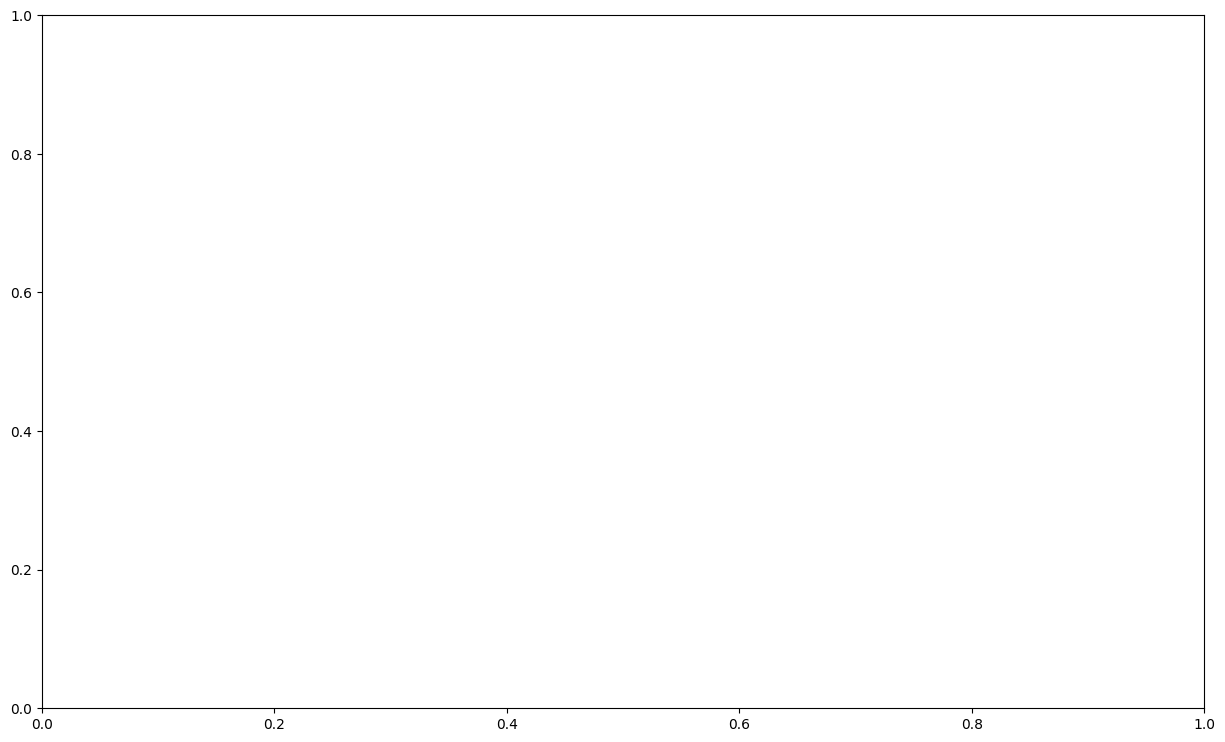

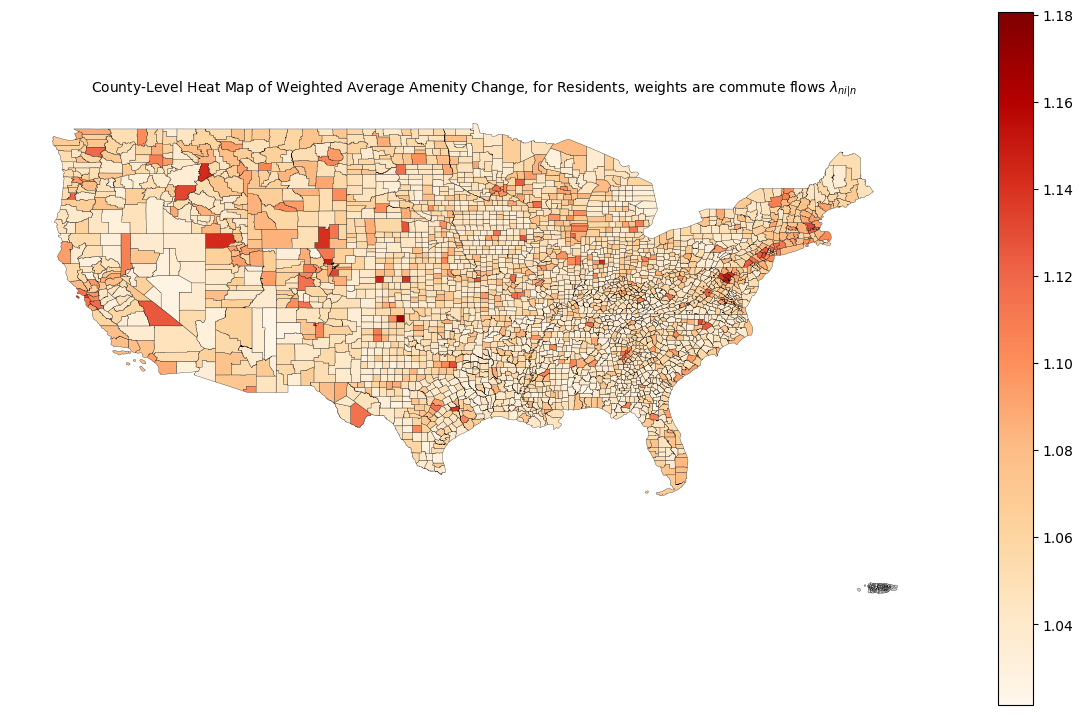

In [310]:
import mapclassify
fig, ax = plt.subplots(1, 1, figsize=(15, 9))

# Exclude AK (02) and HI (15):
lower48 = df_map[~df_map["STATEFP10"].isin(["02", "15"])]

fig, ax = plt.subplots(1, 1, figsize=(15, 9))
lower48.plot(
    column="score",
    ax=ax,
    cmap="OrRd",
    edgecolor="black",
    linewidth=0.2,
    legend=True,
    missing_kwds={"color": "lightgrey"}
)
ax.set_title(plot_title, fontsize=10)
ax.axis("off")

plt.savefig("../output/shocks_by_residence.png", dpi=300, bbox_inches="tight")
plt.show()



In [311]:
%pip install mapclassify


[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [313]:
pi_ni

array([[1.10708896e-03, 1.36499561e-03, 2.49886680e-04, ...,
        9.43617256e-08, 3.94801000e-08, 3.00513831e-08],
       [3.57040612e-04, 7.24183246e-03, 2.63710318e-04, ...,
        1.41471366e-07, 5.91903514e-08, 4.50543926e-08],
       [3.23905384e-04, 1.30682015e-03, 7.90639926e-04, ...,
        9.59381761e-08, 4.01396728e-08, 3.05534354e-08],
       ...,
       [6.95555277e-08, 5.27624921e-04, 5.45572125e-08, ...,
        2.06309683e-03, 2.02624842e-04, 1.22272232e-04],
       [7.18020181e-08, 5.54297412e-04, 5.63192903e-08, ...,
        4.99937046e-04, 8.73236383e-04, 1.99467139e-04],
       [7.03494796e-08, 5.71792552e-04, 5.51799639e-08, ...,
        3.88318865e-04, 2.56749364e-04, 6.38924970e-04]])

In [320]:
import numpy as np

def get_array_stats(arr):
    """
    Calculate summary statistics for a NumPy array
    
    Args:
        arr: NumPy array of numerical values
        
    Returns:
        dict: Dictionary containing summary statistics
    """
    stats = {
        'mean': np.mean(arr),
        'median': np.median(arr),
        'std': np.std(arr),
        'min': np.min(arr),
        'max': np.max(arr),
        'q1': np.percentile(arr, 25),
        'q3': np.percentile(arr, 75),
        'count': len(arr)
    }
    return stats


results = get_array_stats(diff)
results
diff.sum()

np.float64(-63006.72039794922)

In [163]:
workwage.mean()

np.float32(35373.566)

In [162]:
vbar_n.mean()

np.float64(37254.090707168114)

In [160]:
R_n.sum()

np.float32(179874700.0)

In [159]:
workemp.sum()

np.int64(179874700)

In [ ]:
pi_ni

In [316]:
row_sums = pi_ni.sum(axis=1)
print(row_sums)

[1. 1. 1. ... 1. 1. 1.]
